# Annotation of Tweets
In order to train a machine learning model we gathered ground truth data from a crowdsourcing task. Alternative to traditional gold standard data collection methods which employ expert annotaters and rely on single right answer for truth, we use an open-sourced crowdsourcing approach which relies on subjectivity the in human interpretations for gathering multiple annotations. The [CrowdTruth framework](https://github.com/CrowdTruth/CrowdTruth) harnesses disagreement to yield higher quality results, rather than eliminating it.

Due to subjectivity in human interpretations of semantic data, disagreement between annotators is naturally produced as more people labeling natural language data. This is especially true in data that is inherently social, on microblogging sites such as Twitter. It is often not obvious in Tweets, which parts of speech are objects or subjects, and who is the intended audience. The inclusion of sarcasm, slang and hidden sentiment all produce ambiguity.

We gather multiple annotations per document, which reflects human subjectivity in the interpretations of each document. We then measure inter-annotator disagreement between each document and each annotaion, using the cosine-similarity measure within a vector space.

Specifically we are interested in gathering data on wether or not a tweet contains news about an event. This result is correlated with certain quality characteristics, also annotated for each tweet.

#### Quality Characteristics

- Advertisement
- Personal Opinion
- Direct Quote
- Sarcasm
- Explicit Language or Graphic Content
- Not in English
- Display Error
- None

#### News Update

- NOT CONTAINS: The Tweet does not contain any news about the Event
- POSSIBLY CONTAINS: The Tweet possibly contains news about the Event
- CONTAINS: The Tweet contains news about the Event

## Steps
1. Transform Raw Data
    - count total annotations per tweet
    - unstack html radio/checkbox values
2. Apply CrowdTruth Framework
    - get annotation vector
    - get document vectors
    - compute document-annotation scores
    - visualize clarity
3. Aggregate
4. Summarize
    - identify correlations between news annotations with certain quality characteristic
    - identify relationships between annotations and clarity
    

## CrowdTruth Framework:
Apply [proven CrowdTruth metrics](http://www.ancad.ro/2015/09/01/crowdtruth-measures-for-language-ambiguity/) exploiting ambiguity in annotations. The example below considers two documents (Tweets), each being annotated by three workers. 

**annotation vectors**
- the annotation of one worker for one document

| doc | worker | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|---|
| 101 | 001 | 0 | 0 | 1 |
| 101 | 002 | 0 | 1 | 0 |
| 101 | 003 | 0 | 0 | 1 |
| 102 | 001 | 1 | 0 | 0 |
| 102 | 002 | 1 | 0 | 0 |
| 102 | 003 | 0 | 1 | 0 |

**document vectors**
- for every sentence, the sum of all annotation vectors

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0 | 1 | 2 |
| 102 | 2 | 1 | 0 |

**document-annotation score**
- the cosine similarity between the document vector and the unit vector for that annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$
- the score is a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0.00 | 0.44 | 0.89 |
| 102 | 0.89 | 0.44 | 0.00 |

Following the CrowdTruth results demonstrated in [this paper](http://www.ancad.ro/2015/09/01/crowdtruth-measures-for-language-ambiguity/), we select a threshold for document-annotation score that yeilds highest agreement between crowd and experts. They showed that the higher this score, the easier it is for a machine as well as human to classify.

#### import tools

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.metrics.pairwise import cosine_similarity

#### import annotation data

In [62]:
cf = pd.read_csv('data/final/cf_report_crowdtest100.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
cf.sort_values(by=['event', 'event_id', 'text'], inplace=True)
cf.shape

(652, 70)

## 1. Transform

In [63]:
print('crowdsourced:')
print('%s unique annotations' % cf['id'].unique().shape[0])
print('%s unique tweets annotated' % cf.groupby(['event', 'event_id']).size().shape[0])

crowdsourced:
652 unique annotations
100 unique tweets annotated


#### count total annotations per tweet

In [64]:
cf_annpertweet = pd.DataFrame(cf.groupby(['event', 'event_id']).size(), columns=['doc_annotations']).reset_index()
cf = pd.merge(cf, cf_annpertweet, how='left', on=['event', 'event_id'])

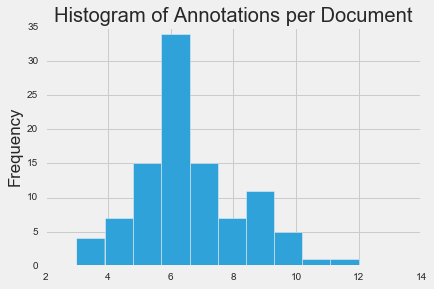

In [65]:
cf.groupby(['event', 'event_id']).size().plot(kind='hist', title='Histogram of Annotations per Document')
plt.show()

#### unstack html radio/checkbox values
- decode "news" to annotation values

In [73]:
annotation_codes = {0.0 : 'NOT CONTAINS',
                    0.5 : 'POSSIBLY CONTAINS',
                    1.0 : 'CONTAINS'}

annotations  = list(annotation_codes.values())

In [158]:
cf['news'].replace(annotation_codes, inplace=True)

for ann in annotations:
    cf[ann] = cf['news'].apply(lambda a: [0,1][a == ann])
    
# characteristics
cf['question'] = cf['characteristics'].apply(lambda q: 1 if 'question' in [i for i in str(q).split('\n')] else 0)
cf['advertisement'] = cf['characteristics'].apply(lambda q: 1 if 'advertisement' in [i for i in str(q).split('\n')] else 0)
cf['opinion'] = cf['characteristics'].apply(lambda q: 1 if 'opinion' in [i for i in str(q).split('\n')] else 0)
cf['quote'] = cf['characteristics'].apply(lambda q: 1 if 'quote' in [i for i in str(q).split('\n')] else 0)
cf['sarcasm'] = cf['characteristics'].apply(lambda q: 1 if 'sarcasm' in [i for i in str(q).split('\n')] else 0)
cf['explicit'] = cf['characteristics'].apply(lambda q: 1 if 'explicit' in [i for i in str(q).split('\n')] else 0)
cf['lang'] = cf['characteristics'].apply(lambda q: 1 if 'lang' in [i for i in str(q).split('\n')] else 0)
cf['error'] = cf['characteristics'].apply(lambda q: 1 if 'error' in [i for i in str(q).split('\n')] else 0)
cf['none'] = cf['characteristics'].isnull().apply(lambda q: 1 if q == True else 0)
#news location
cf['news_in_text'] = cf['news_location'].apply(lambda q: 1 if 'text' in [i for i in str(q).split('\n')] else 0)
cf['news_in_media'] = cf['news_location'].apply(lambda q: 1 if 'media' in [i for i in str(q).split('\n')] else 0)
cf['news_in_link'] = cf['news_location'].apply(lambda q: 1 if 'link' in [i for i in str(q).split('\n')] else 0)

## 2. Apply CrowdTruth Framework
#### annotation vectors
- using [event, event_id] as unique doc id's
- because integrity of twitter_id was lost (CrowdFlower could not handle)

In [84]:
cols = ['event', 'event_id',  'text', 'id', 'doc_annotations']
cols.extend(annotations)
anno_vectors = cf[cols]

In [85]:
anno_vectors.head()

,event,event_id,text,id,doc_annotations,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
0,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,2001383247,5,0,1,0
1,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,2001383728,5,0,0,1
2,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,2001383833,5,1,0,0
3,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,2001388390,5,1,0,0
4,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,2001388753,5,0,1,0


#### document vectors
- define annotation list for automating below

In [86]:
doc_vectors = cf.groupby(['event', 'event_id', 'text', 'doc_annotations'])[annotations].sum()

In [87]:
doc_vectors.reset_index().head()

,event,event_id,text,doc_annotations,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
0,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,5,2,2,1
1,EgyptAir Flight 804,3440,Praying for those onboard #EgyptAir 🙏,6,3,2,1
2,EgyptAir Flight 804,3575,Think Obama had it shot down because it didn’t...,4,1,1,2
3,EgyptAir Flight 804,4454,#Egyptair flight with 59 passengers and 10 cr...,7,0,4,3
4,EgyptAir Flight 804,5614,I don't understand how can in this day and age...,6,1,1,4


#### unit vectors
- construct square matrix, of unit verctors
- where diagonal to 1

In [88]:
a = np.zeros([len(annotations), len(annotations)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=annotations, columns=annotations)

In [89]:
unit_vectors

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
NOT CONTAINS,1.0,0.0,0.0
POSSIBLY CONTAINS,0.0,1.0,0.0
CONTAINS,0.0,0.0,1.0


#### document-annotation score (clarity)
- compute the cosine similarity between each document vector and the unit vector for every annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$
- the score is a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine


In [90]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=annotations)

In [91]:
doc_anno_scores.head()

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
0,0.666667,0.666667,0.333333
1,0.801784,0.534522,0.267261
2,0.408248,0.408248,0.816497
3,0.000000,0.800000,0.600000
4,0.235702,0.235702,0.942809


#### visualize

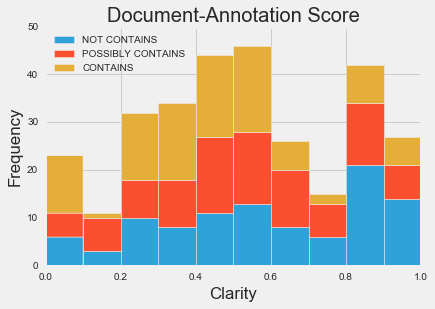

In [92]:
ax = doc_anno_scores.plot(kind='hist', stacked=True, alpha=1)
ax.set_title('Document-Annotation Score')
ax.set_xlabel('Clarity')
plt.show()

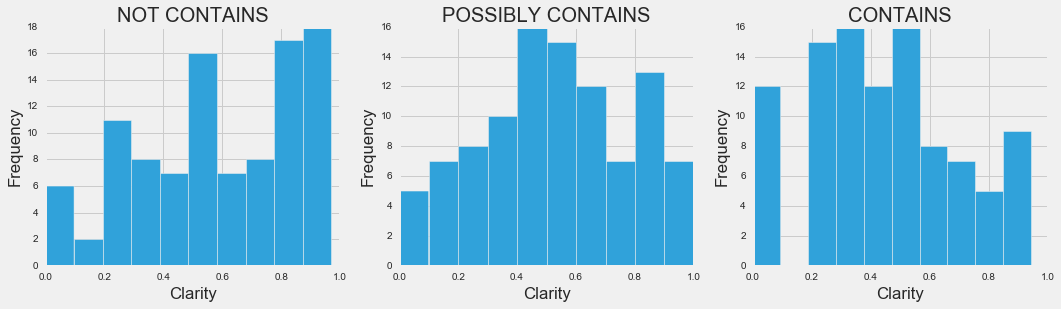

In [93]:
fig, axs = plt.subplots(1,len(annotations), figsize=(16, 4))
for i,ann in enumerate(doc_anno_scores.columns):
    axs[i].hist(doc_anno_scores[ann])
    axs[i].set_title(ann[i])
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Clarity')
plt.show()

#### merge scores to data

In [125]:
doc_anno_scores.columns = [ann+' clarity' for ann in annotations]

In [37]:
results = pd.merge(doc_vectors.reset_index(), doc_anno_scores, left_index=True, right_index=True)

In [38]:
results.head()

,event,event_id,text,doc_annotations,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS,NOT CONTAINS clarity,POSSIBLY CONTAINS clarity,CONTAINS clarity
0,EgyptAir Flight 804,1486,#EgyptAir Al Jazeera English : EgyptAir has co...,5,2,2,1,0.666667,0.666667,0.333333
1,EgyptAir Flight 804,3440,Praying for those onboard #EgyptAir 🙏,6,3,2,1,0.801784,0.534522,0.267261
2,EgyptAir Flight 804,3575,Think Obama had it shot down because it didn’t...,4,1,1,2,0.408248,0.408248,0.816497
3,EgyptAir Flight 804,4454,#Egyptair flight with 59 passengers and 10 cr...,7,0,4,3,0.000000,0.800000,0.600000
4,EgyptAir Flight 804,5614,I don't understand how can in this day and age...,6,1,1,4,0.235702,0.235702,0.942809


#### plot annotation clarity

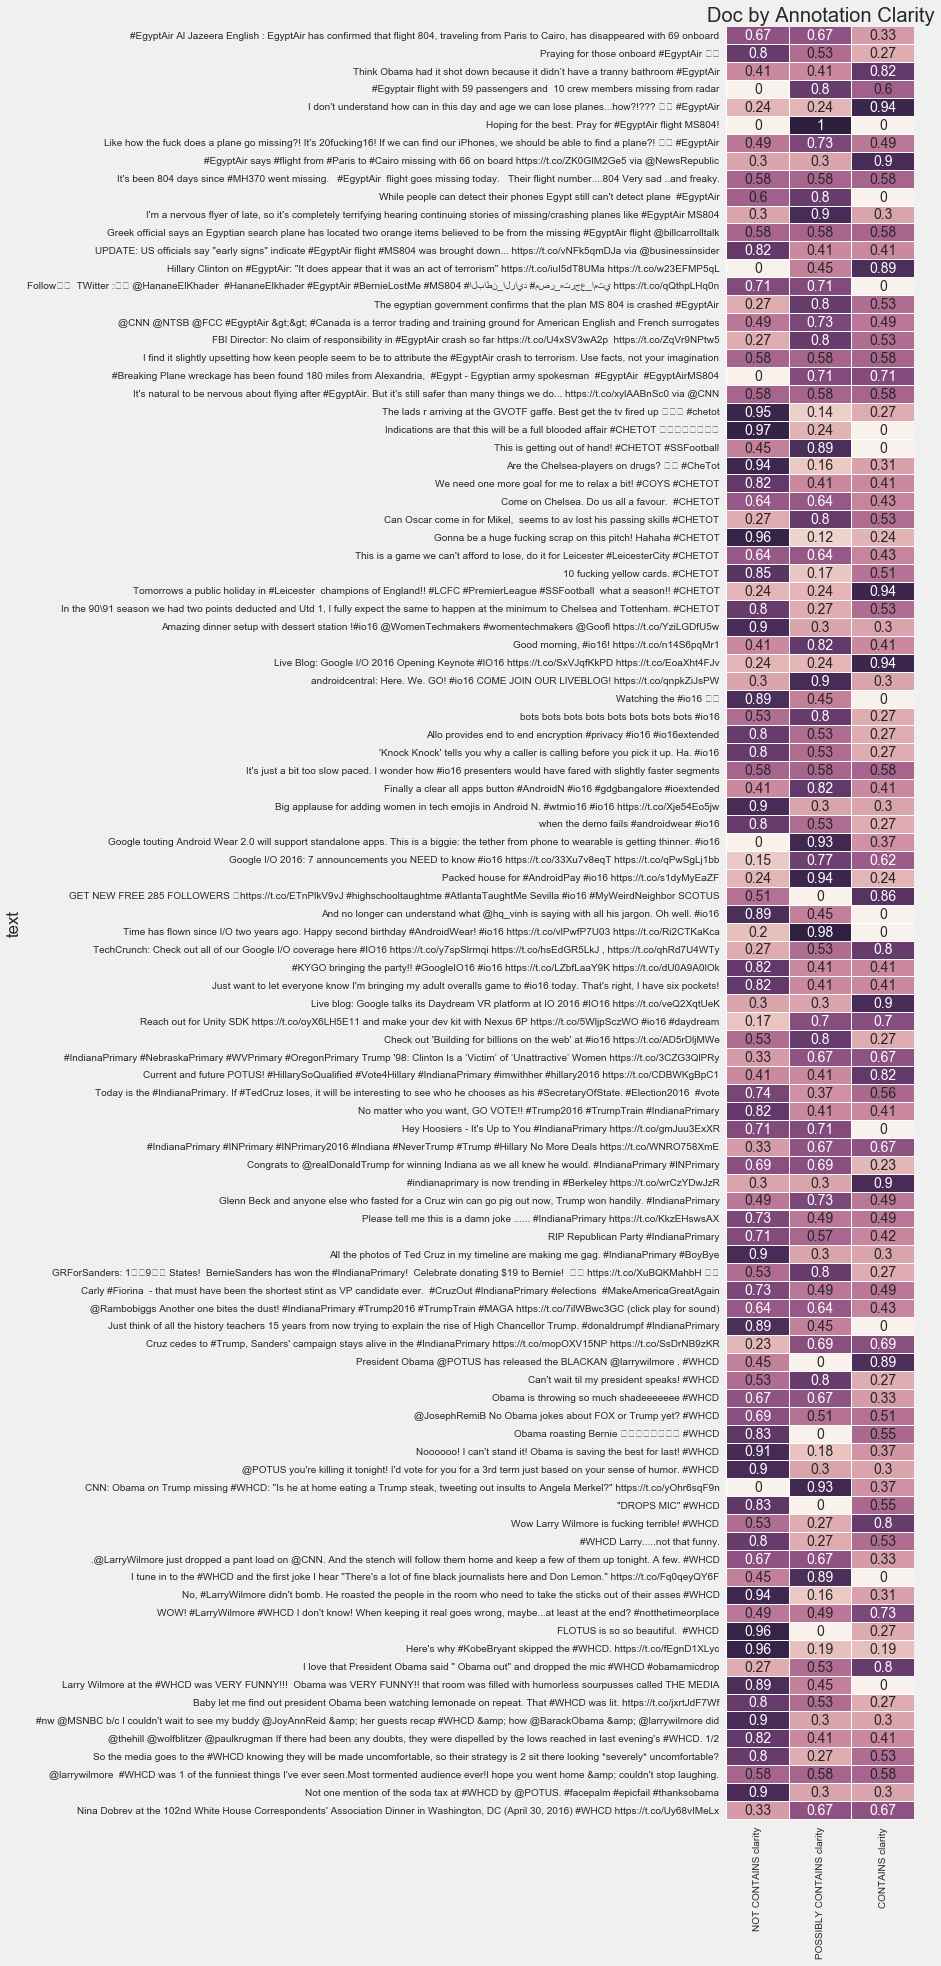

In [39]:
x = results.set_index('text')[doc_anno_scores.columns]
plt.figure(figsize=(3, 30))
ax = sns.heatmap(x, annot=True, linewidths=.01, cbar=False)
sns.plt.title('Doc by Annotation Clarity')
plt.show()

## Compare to Manually Annotated (Strict)

#### News
- import manually annotated
- merge crowd annotations with expert
- export this data (for manual analysis in excel)

In [110]:
cf_man = pd.read_csv('data/final/cf_report_manualtest100.csv', sep=',', encoding='utf-8', header=0)
cf_man.sort_values(by=['event', 'event_id', 'text'], inplace=True)
cf_man.shape

(100, 69)

In [111]:
print('expert:')
print('%s unique annotations' % cf_man['id'].unique().shape[0])
print('%s unique tweets annotated' % cf_man.groupby(['event', 'event_id']).size().shape[0])

expert:
100 unique annotations
100 unique tweets annotated


In [112]:
cf_man['news'].replace(annotation_codes, inplace=True)

for ann in annotations:
    cf_man[ann] = cf_man['news'].apply(lambda a: [0,1][a == ann])

In [113]:
results_crowd = results.set_index(['event', 'event_id', 'text'])
results_manual = cf_man.set_index(['event', 'event_id', 'text'])[annotations]

results_out = pd.merge(results_crowd, results_manual, left_index=True, right_index=True)

results_out.to_csv('annotation_results.txt', sep='\t')

## 3. Aggregate
- using majority vote
    - that annotation which is > 50% of annotations is accepted

In [184]:
x = cf.groupby(['event', 'event_id'])[annotations].agg(['sum'])
x.columns = x.columns.droplevel(1)

cf_agg_news = pd.DataFrame(x.apply(lambda row: [0,1][row['CONTAINS'] > (row.sum() / 2)], axis=1), columns=['news'])

In [185]:
x = cf.groupby(['event', 'event_id', 'doc_annotations'])[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].agg(['sum'])
x.columns = x.columns.droplevel(1)
x.reset_index(level='doc_annotations', inplace=True)

x['question'] = x.apply(lambda row: [0,1][row['question'] > (row['doc_annotations'] / 2)] , axis=1)
x['advertisement'] = x.apply(lambda row: [0,1][row['advertisement'] > (row['doc_annotations'] / 2)] , axis=1)
x['opinion'] = x.apply(lambda row: [0,1][row['opinion'] > (row['doc_annotations'] / 2)] , axis=1)
x['quote'] = x.apply(lambda row: [0,1][row['quote'] > (row['doc_annotations'] / 2)] , axis=1)
x['sarcasm'] = x.apply(lambda row: [0,1][row['sarcasm'] > (row['doc_annotations'] / 2)] , axis=1)
x['explicit'] = x.apply(lambda row: [0,1][row['explicit'] > (row['doc_annotations'] / 2)] , axis=1)
x['lang'] = x.apply(lambda row: [0,1][row['lang'] > (row['doc_annotations'] / 2)] , axis=1)
x['error'] = x.apply(lambda row: [0,1][row['error'] > (row['doc_annotations'] / 2)] , axis=1)

x['none'] = x.apply(lambda row: [0,1][row[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].sum() == 0], axis=1)

In [186]:
cf_agg = pd.merge(x, cf_agg_news, how='inner', left_index=True, right_index=True)
cf_agg.shape

(100, 11)

#### export aggregate annotaions

In [188]:
cf_agg.reset_index().to_csv('data/final/tweet_annotations_agg.csv', sep='\t', encoding='utf-8', header=True, index=False)

## 4. Summarize
- high level summary

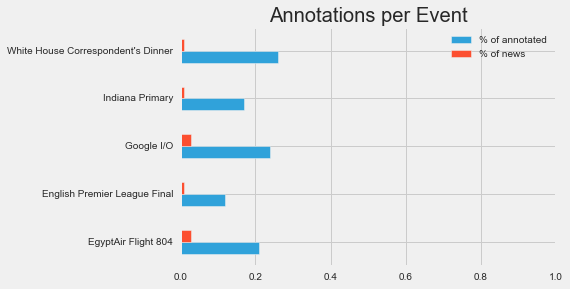

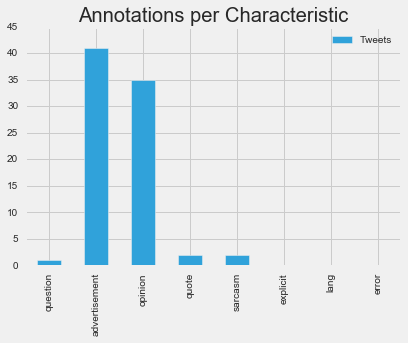

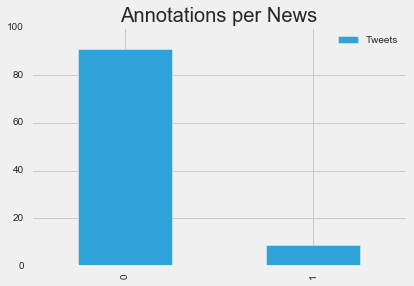

In [189]:
d1 = cf_agg.reset_index()['event'].value_counts(normalize=True)
d2 = cf_agg.reset_index().groupby('event')['news'].sum() / cf_agg.shape[0]
d = pd.merge(pd.DataFrame(d1), pd.DataFrame(d2), left_index=True, right_index=True)
d.columns = ['% of annotated', '% of news']
d.plot(kind='barh', xlim=[0,1], title='Annotations per Event')
plt.show()

d = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].apply(pd.Series.value_counts).iloc[1]
d.plot(kind='bar', title='Annotations per Characteristic', label='Tweets')
plt.legend(loc='best')
plt.show()

d = cf_agg['news'].value_counts()
d.plot(kind='bar', title='Annotations per News', label='Tweets')
plt.legend(loc='best')
plt.show()

- in depth summary

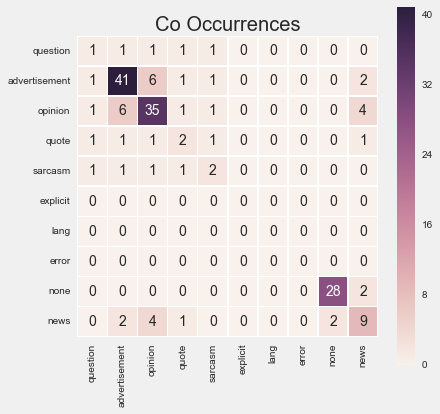

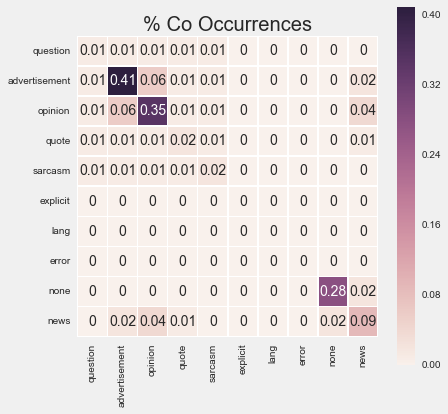

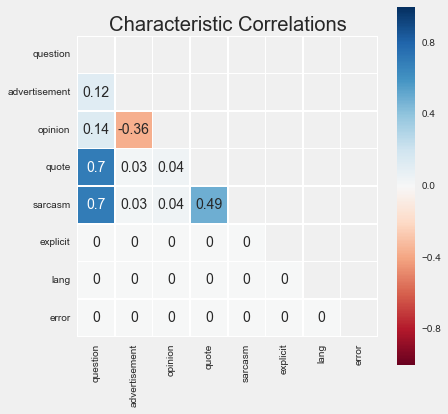

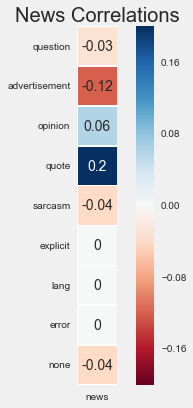

In [190]:
x = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none', 'news']]

plt.figure(figsize=(6,6))
ax = sns.heatmap((x.T.dot(x)), annot=True, square=True, linewidths=.5)
plt.title('Co Occurrences')
sns.plt.show()

plt.figure(figsize=(6,6))
ax = sns.heatmap(round(x.T.dot(x) / cf_agg.shape[0], 2), annot=True, square=True, linewidths=.5)
plt.title('% Co Occurrences')
sns.plt.show()

xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].corr()
mask = np.full(xcorr.shape, False, dtype=bool)
mask[np.triu_indices(len(xcorr))] = True
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, mask=mask, cmap='RdBu', linewidths=.5)
plt.title('Characteristic Correlations')
sns.plt.show()

xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
xcorr = pd.DataFrame(xcorr, columns=['news'])
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
plt.title('News Correlations')
sns.plt.show()